<a href="https://colab.research.google.com/github/lourencocavalcante/Neurocomputacao/blob/main/CAP351_Projeto_01_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[<img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/logoinpe.png?raw=true" align="middle">](https://www.gov.br/inpe/pt-br)

[<center><img src="https://github.com/lourencocavalcante/LogosINPE/blob/main/LogoCAP.png?raw=true" width = 500 align="middle"></center>](http://www.inpe.br/posgraduacao/cap/)


---


# **CAP-351 Neurocomputação**

**Professor:**

* Dr. Marcos Goncalves Quiles

**Aluno:**
* Lourenço José Cavalcante Neto

# PROPOSTA DE PROJETO 1:

# REDE MLP:: Multi-layer Perceptron (MLP)

1. Selecionar dois datasets (não triviais)

  * Um dataset para classificação
  * Um dataset para regressão
  * Separar em treino/validação/teste

2. Treinar modelos MLP para os dois problemas

3. Considerar:
  * Diferentes topologias (>=5 topologias, variar número de
camadas)
  * Usar o algoritmo original SGD (não usar algoritmos otimizados,
e.g. ADAM)
  * Avaliar o impacto do uso do Momentum
  * Avaliar o impacto do uso da regularização (i.e. L2)

4. Ilustrar graficamente a evolução do treinamento (treino/validação).

5. Confeccionar um relatório (reprodutível) contendo os
experimentos e resultados

In [42]:
import pandas as pd

import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.8.2


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Dataset**

Importando os dados do **disdrômetro RD80 (Joss**) e do radiômetro de microondas **MP3000A**.


In [101]:
#CRIANDO OS DATAFRAMES
#Dados do disdrômetro RD80. Chamado comumente de Joss. 
#Este equipamento mede adistribuição das gotas de chuva que chegam à superfície. (df_rd80_joss)
df_rd80_joss = pd.read_table('/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/JWD_campina_report_RZLwcDmDtNdrop_b2.1_report.txt',header=None,delim_whitespace=True)


#Dados do radiômetro de microondas MP3000A. Esse instrumento mede diversas variáveis:

#Variáveis de ambiente (dados_ambi_superficie)
df_mp3000A_1 = pd.read_table('/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/level1_output_sfc.txt',header=None,delim_whitespace=True)
#Radiância no espectro de onda do microonda em diversos canais (dados_med_canais_micro)
df_mp3000A_2 = pd.read_table('/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/level1_output_bt.txt',header=None,delim_whitespace=True)
#Estimativas de parâmetros de nuvens (dados_est_param_nuvens)
df_mp3000A_3 = pd.read_table('/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/level2_output_cld_atto.txt',header=None,delim_whitespace=True)

In [102]:
#Os Dataframes estão sem título nas colunas. Vamos adicioná-las.

df_rd80_joss.columns = ['Ano (YYYY)', 'Mes', 'dia', 'H', 'M', 'S','Rain Intensity (mm/h)', 'radar reflectivity (1/mm6m3)','Liquid watercontent (g/m3)',
'Mean weight diameter(mm)', 'Time integration (s)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)', 'N(D)']

df_mp3000A_1.columns = ['Mes', 'dia', 'Ano (YY)', 'H', 'M', 'S', 'Tamb(K)', 'Rh(%)', 'Pres(mb)', 'Tir(K)', 'Rain', 'DataQuality']
df_mp3000A_2.columns = ['Mes', 'dia', 'Ano (YY)', 'H', 'M', 'S', 'Ch 22.234', 'Ch 22.500', 'Ch 23.034', 'Ch 23.834', 'Ch 25.000', 'Ch 26.234', 'Ch 28.000', 'Ch 30.000', 'Ch 51.248', 'Ch 51.760', 'Ch 52.280', 'Ch 52.804', 'Ch 53.336', 'Ch 53.848', 'Ch 54.400', 'Ch 54.940', 'Ch 55.500', 'Ch 56.020', 'Ch 56.660', 'Ch 57.288', 'Ch 57.964', 'Ch 58.800', 'DataQuality']
df_mp3000A_3.columns = ['Mes', 'dia', 'Ano (YY)', 'H', 'M', 'S', 'Int. Vapor(cm)','Int. Liquid(mm)','Cloud Base(km)','DataQuality']

In [103]:
#Modificanto o tipo de dado das colunas referentes a Data e Horário para Inteiro
df_rd80_joss[['Ano (YYYY)', 'Mes', 'dia', 'H', 'M', 'S']] = df_rd80_joss[['Ano (YYYY)', 'Mes', 'dia', 'H', 'M', 'S']].astype(int)
df_mp3000A_3[['Mes', 'dia', 'Ano (YY)', 'H', 'M', 'S']] = df_mp3000A_3[['Mes', 'dia', 'Ano (YY)', 'H', 'M', 'S']].astype(int)
df_mp3000A_2[['Mes', 'dia', 'Ano (YY)', 'H', 'M', 'S']] = df_mp3000A_2[['Mes', 'dia', 'Ano (YY)', 'H', 'M', 'S']].astype(int)
df_mp3000A_3[['Mes', 'dia', 'Ano (YY)', 'H', 'M', 'S']] = df_mp3000A_3[['Mes', 'dia', 'Ano (YY)', 'H', 'M', 'S']].astype(int)

In [104]:
df_rd80_joss.shape

(315420, 31)

In [105]:
df_rd80_joss.isna().sum()

Ano (YYYY)                      0
Mes                             0
dia                             0
H                               0
M                               0
S                               0
Rain Intensity (mm/h)           0
radar reflectivity (1/mm6m3)    0
Liquid watercontent (g/m3)      0
Mean weight diameter(mm)        0
Time integration (s)            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)                            0
N(D)          

In [97]:
df_rd80_joss.dropna(inplace=True)
df_rd80_joss.reset_index(inplace=True, drop=True)

In [110]:
df_rd80_joss.shape[0]

315420

In [106]:
indexes = ['Ano (YYYY)', 'Mes', 'dia', 'H', 'M', 'S','Rain Intensity (mm/h)', 'radar reflectivity (1/mm6m3)','Liquid watercontent (g/m3)',
'Mean weight diameter(mm)', 'Time integration (s)']

df_final_rd80_joss = df_rd80_joss[indexes]

In [ ]:
cont = df_rd80_joss.shape[0]
for index, row in df_final_rd80_joss.iterrows():
  #ano = '20' + str(int(row['Ano (YYYY)']))
  ano = str(int(row['Ano (YYYY)']))
  mes = '%02d' % int(row['Mes'])
  dia = '%02d' % int(row['dia'])
  h = '%02d' % int(row['H'])
  m = '%02d' % int(row['M'])
  s = '%02d' % int(row['S'])
    

  #print(mes)
  df_final_rd80_joss.loc[index, 'Data'] = str(dia) + '-' + str(mes) + '-'+ str(ano)
  #df_mp3000A_3.loc[index, 'Horario'] = str(h) + ':' + str(m) + ':'+ str(s)
  cont = cont - 1
  print(cont)

In [120]:
df_final_rd80_joss

,Ano (YYYY),Mes,dia,H,M,S,Rain Intensity (mm/h),radar reflectivity (1/mm6m3),Liquid watercontent (g/m3),Mean weight diameter(mm),Time integration (s),Data
0,2020,3,17,13,52,0,0.00000,0.00000,0.00000,0.00000,60.0,17-03-2020
1,2020,3,17,13,53,0,0.00000,0.00000,0.00000,0.00000,60.0,17-03-2020
2,2020,3,17,13,54,0,0.00000,0.00000,0.00000,0.00000,60.0,17-03-2020
3,2020,3,17,13,55,0,0.00000,0.00000,0.00000,0.00000,60.0,17-03-2020
4,2020,3,17,13,56,0,0.00000,0.00000,0.00000,0.00000,60.0,17-03-2020
...,...,...,...,...,...,...,...,...,...,...,...,...
315415,2022,6,29,9,5,0,0.00321,0.06064,0.00059,0.37325,60.0,29-06-2022
315416,2022,6,29,9,6,0,0.00409,0.08150,0.00074,0.38193,60.0,29-06-2022
315417,2022,6,29,9,7,0,0.00558,0.12418,0.00095,0.40371,60.0,29-06-2022
315418,2022,6,29,9,8,0,0.00497,0.10235,0.00088,0.38777,60.0,29-06-2022


In [176]:
df_final_rd80_joss.to_csv('/content/drive/MyDrive/MestradoCAP/Lourenco/cap351/Datasets/df_final_rd80_joss.csv')

In [177]:
indexes2 = ['H', 'M', 'S','Rain Intensity (mm/h)', 'radar reflectivity (1/mm6m3)','Liquid watercontent (g/m3)',
'Mean weight diameter(mm)', 'Time integration (s)']

df_final2_rd80_joss = df_rd80_joss[indexes2]

In [180]:
df_final2_rd80_joss.isna().sum()

H                               0
M                               0
S                               0
Rain Intensity (mm/h)           0
radar reflectivity (1/mm6m3)    0
Liquid watercontent (g/m3)      0
Mean weight diameter(mm)        0
Time integration (s)            0
dtype: int64

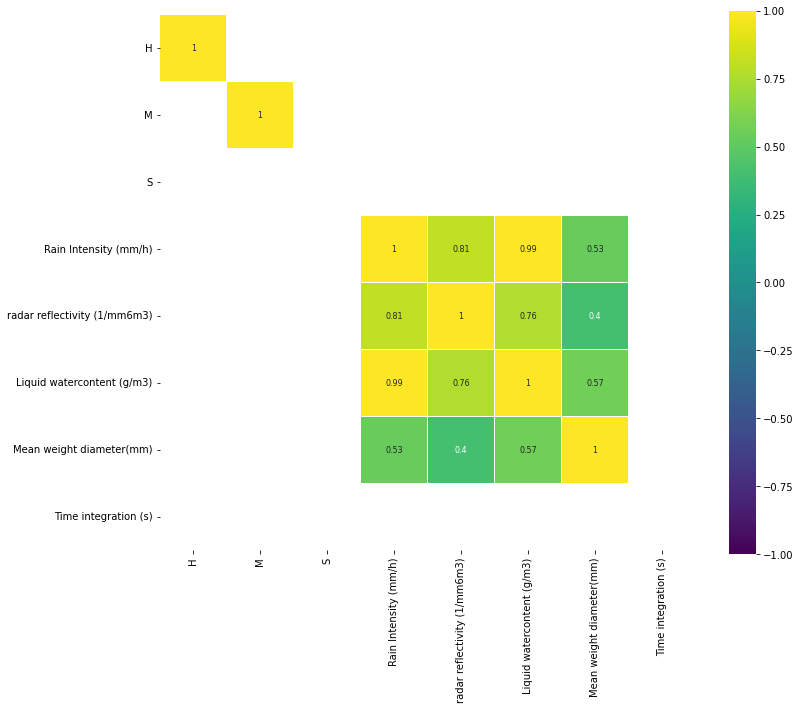

In [181]:
corr = df_final2_rd80_joss.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr[(corr >= 0.30) | (corr <= -0.30)],cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1, annot=True, annot_kws={"size": 8}, square=True);

[]

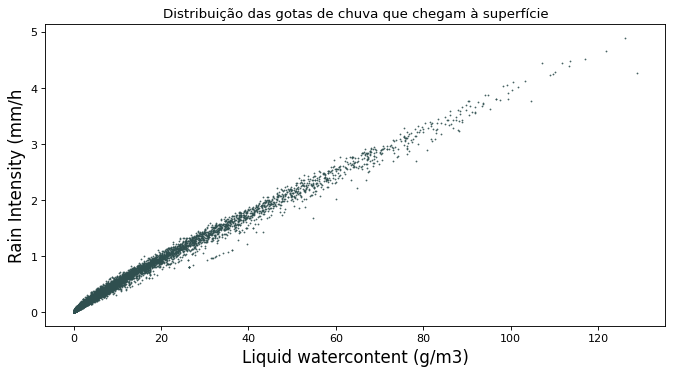

In [185]:
#from IPython.core.pylabtools import figsize
figure(figsize=(10,5),dpi=80)
plt.scatter(df_final2_rd80_joss['Rain Intensity (mm/h)'] ,df_final2_rd80_joss['Liquid watercontent (g/m3)'],s=0.3, color='#2F4F4F')
#plt.xscale('log')
plt.xlabel(r'Liquid watercontent (g/m3)',size=15)
plt.ylabel(r'Rain Intensity (mm/h',size=15)
plt.title("Distribuição das gotas de chuva que chegam à superfície")
plt.plot()

63084
252336


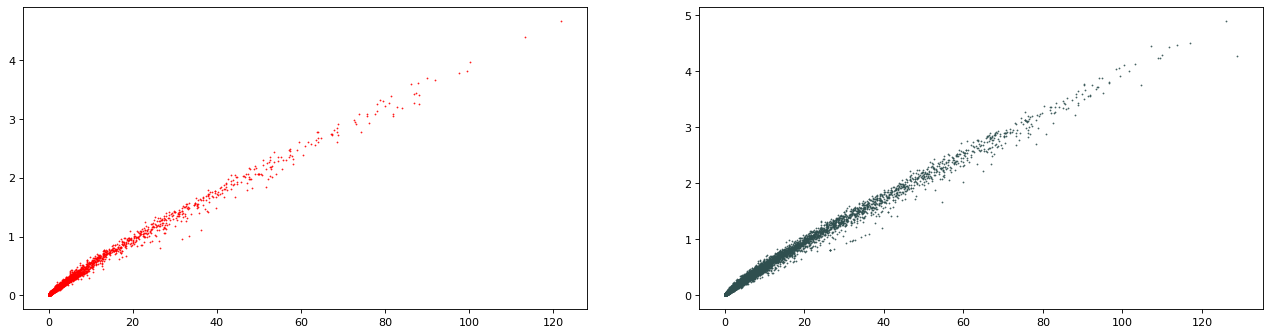

In [187]:
# Separação em treinamento e validação
x_train, x_test, y_train, y_test = train_test_split(df_final_rd80_joss['Rain Intensity (mm/h)'] ,df_final_rd80_joss['Liquid watercontent (g/m3)'], test_size=0.8)
print(len(x_train))
print(len(x_test))
figure(figsize=(20,5),dpi=80)
plt.subplot(1,2,1)
plt.scatter(x_train, y_train, color='#FF0000',s=0.3)
plt.subplot(1,2,2)
plt.scatter(x_test, y_test, color='#2F4F4F',s=0.3)
plt.show()

**Modelo 1**

Para tentar construir uma rede capaz de encontrar uma lei de regressão para esses problemas, serão geradas 5 topologias de rede diferentes. O primeiro será o caso simples e clássico de um perceptron e o segundo aumentará o número de camadas e o número de neurônios.

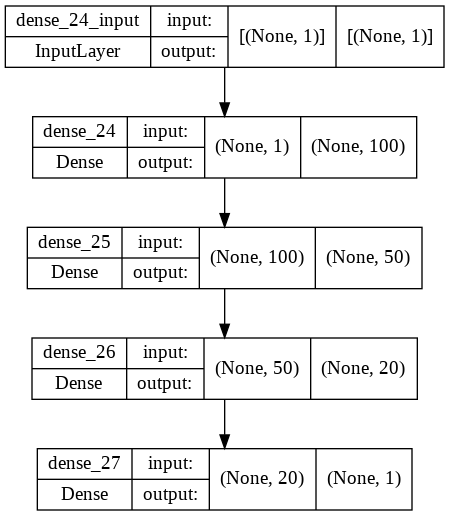

In [188]:
fl2 = 0.0
drop = 0.2

# model = keras.Sequential()
# model.add(keras.layers.Dense(units=100, kernel_regularizer=l2(fl2), input_shape=[1], activation="tanh"))
# model.add(Dropout(drop))
# model.add(keras.layers.Dense(units=50, kernel_regularizer=l2(fl2), activation="tanh"))
# model.add(Dropout(drop))
# model.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="tanh"))
# model.add(keras.layers.Dense(units=20, kernel_regularizer=l2(fl2), activation="tanh"))
# model.add(keras.layers.Dense(units=1, activation="linear"))

model = keras.Sequential()
model.add(keras.layers.Dense(units=100, input_shape=[1], activation="tanh"))
model.add(keras.layers.Dense(units=50, activation="tanh"))
model.add(keras.layers.Dense(units=20, activation="tanh"))
model.add(keras.layers.Dense(units=1, activation="linear"))


sgd = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.0)
adam = tf.keras.optimizers.Adam()

model.compile(loss='mean_squared_error', optimizer=sgd, metrics=["mean_absolute_error"])

tf.keras.utils.plot_model(model, show_shapes=True)

**Treino**

In [189]:
early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100)

history = model.fit(x_train, y_train, epochs=20, batch_size=10, #3000
                    validation_split=0.2, 
                    verbose=True)#False, 
                    #callbacks=[early])

#print("Network parameters: {}".format(model.get_weights()))

Epoch 1/20
5047/5047 [==============================] - 12s 2ms/step - loss: 0.0012 - mean_absolute_error: 0.0045 - val_loss: 6.1608e-04 - val_mean_absolute_error: 0.0024
Epoch 2/20
5047/5047 [==============================] - 12s 2ms/step - loss: 5.1273e-04 - mean_absolute_error: 0.0033 - val_loss: 4.7844e-04 - val_mean_absolute_error: 0.0029
Epoch 3/20
5047/5047 [==============================] - 12s 2ms/step - loss: 4.7561e-04 - mean_absolute_error: 0.0031 - val_loss: 4.0406e-04 - val_mean_absolute_error: 0.0021
Epoch 4/20
5047/5047 [==============================] - 12s 2ms/step - loss: 4.2430e-04 - mean_absolute_error: 0.0030 - val_loss: 4.1684e-04 - val_mean_absolute_error: 0.0027
Epoch 5/20
5047/5047 [==============================] - 12s 2ms/step - loss: 3.7313e-04 - mean_absolute_error: 0.0029 - val_loss: 5.6045e-04 - val_mean_absolute_error: 0.0033
Epoch 6/20
5047/5047 [==============================] - 12s 2ms/step - loss: 3.6012e-04 - mean_absolute_error: 0.0028 - val_loss:

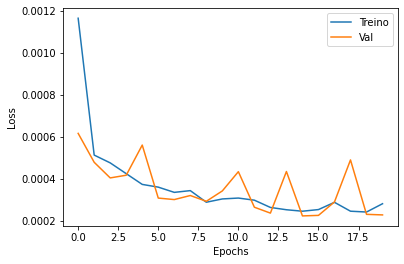

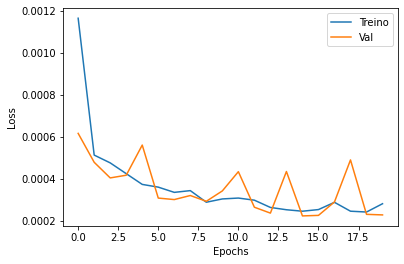

In [190]:
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'], label="Treino")
plt.plot(history.history['val_loss'], label="Val")
plt.legend()
plt.show()

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(history.history['loss'][-100:], label="Treino")
plt.plot(history.history['val_loss'][-100:], label="Val")
plt.legend()
plt.show()

**Avaliação (teste)**

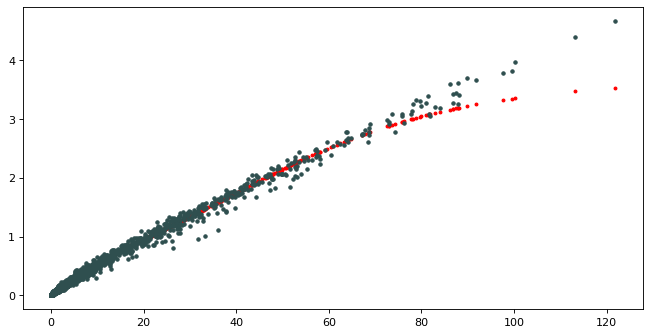

In [191]:
y_rest = model.predict(x_train)
figure(figsize=(10,5),dpi=80)
plt.plot(x_train, y_rest, '.', markersize=5 ,color='#FF0000')
plt.plot(x_train, y_train, '.', color='#2F4F4F')
plt.show()

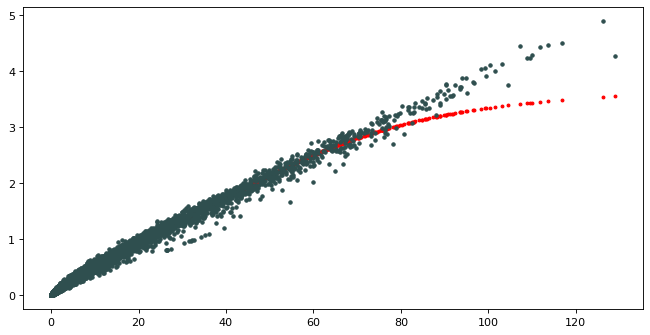

7886/7886 [==============================] - 13s 2ms/step - loss: 1.6679e-04 - mean_absolute_error: 0.0018


In [192]:
y_res = model.predict(x_test)
figure(figsize=(10,5),dpi=80)
plt.plot(x_test, y_res, '.', markersize=5, color='#FF0000')
plt.plot(x_test, y_test, '.', color='#2F4F4F')
plt.show()

test_loss = model.evaluate(x_test, y_test)

In [193]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test metric:", score[1])

Test loss: 0.0001667938195168972
Test metric: 0.0017571230418980122


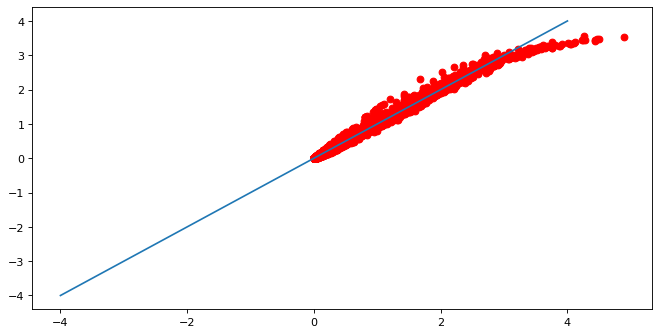

In [194]:
figure(figsize=(10,5),dpi=80)
plt.scatter(y_test, y_res, color='#FF0000')

plt.plot([-4,4], [-4,4])
plt.show()